<a href="https://colab.research.google.com/github/mariaob1201/geo_analysis_smoke_data/blob/main/smokedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HRRR-smoke data in the AWS S3 bucket

From https://registry.opendata.aws/collab/noaa/

In [1]:
!pip install s3fs
import s3fs

In [3]:
aws_cred = s3fs.S3FileSystem()
aws_cred.key

In [7]:
aws_cred

In [1]:
!pip install boto3

In [5]:
import boto3

# ARN of the S3 bucket
bucket_name = 'noaa-hrrr-bdp-pds'

# AWS region
region_name = 'us-east-1'

# Create a session with anonymous access
session = boto3.Session(region_name=region_name)

# Create an S3 resource using the session
s3 = session.resource('s3')

# Get the bucket object
bucket = s3.Bucket(bucket_name)




In [6]:
bucket

s3.Bucket(name='noaa-hrrr-bdp-pds')

In [7]:
# List objects in the bucket
for obj in bucket.objects.all():
    print(obj.key)

NoCredentialsError: Unable to locate credentials

In [6]:
bucket_name = 'your-s3-bucket-name'
files = aws_cred.ls(bucket_name)
for f in files:
 print(f)

NoCredentialsError: Unable to locate credentials

In [3]:
import boto3

# Create an S3 client without providing credentials
s3_client = boto3.client('s3', region_name='us-east-1', aws_access_key_id='', aws_secret_access_key='')

# List objects in the bucket
response = s3_client.list_objects_v2(Bucket='noaa-hrrr-bdp-pds')

# Print object keys
for obj in response.get('Contents', []):
    print(obj['Key'])


ClientError: An error occurred (AuthorizationHeaderMalformed) when calling the ListObjectsV2 operation: The authorization header is malformed; a non-empty Access Key (AKID) must be provided in the credential.

### Exploring the data

In [8]:
!pip install s3fs zarr cartopy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=1a75d1ab0f6189963d0ff434f50c269deaa7c0943c96eb6225dac4bd5298ae84
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [9]:
aws_cred= s3fs.S3FileSystem(anon=True)


In [11]:
import zarr

In [12]:
# Reading the data
store = zarr.open(s3fs.S3Map("s3://hrrrzarr", s3=aws_cred))


In [13]:
smoke = store["sfc/20220906/20220906_00z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN"]


In [14]:
coords= store["grid/HRRR_chunk_index.zarr"]


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


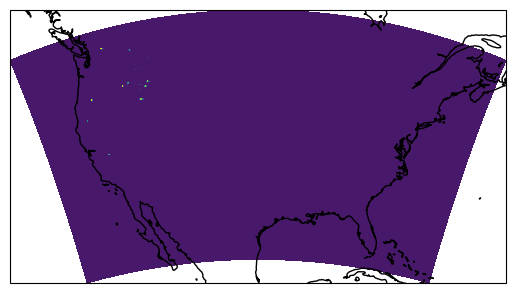

In [15]:
import cartopy.crs as crs
import matplotlib.pyplot as plt


ax = plt.axes(projection=crs.Mercator())
ax.contourf(coords["longitude"], coords["latitude"], smoke, transform=crs.PlateCarree())
ax.coastlines()
plt.show()

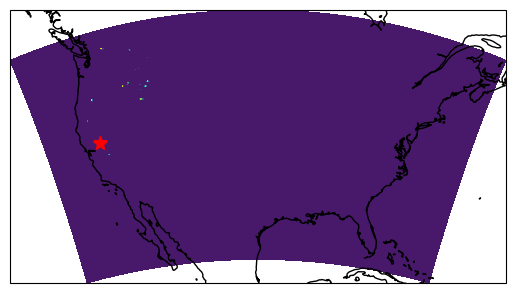

In [20]:
ax = plt.axes(projection=crs.Mercator())
ax.contourf(coords["longitude"], coords["latitude"], smoke, transform=crs.PlateCarree())
ax.plot(-120.7447,39.00591,'r*',markersize=10,transform=crs.PlateCarree())
ax.coastlines()
plt.show()

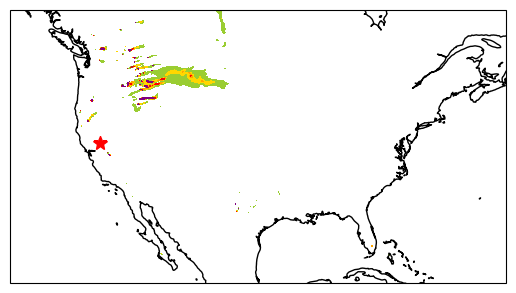

In [25]:
ax = plt.axes(projection=crs.Mercator())
ax.contourf(coords["longitude"], coords["latitude"], smoke, transform=crs.PlateCarree())
ax.plot(-120.7447,39.00591,'r*',markersize=10,transform=crs.PlateCarree())

cmap = colors.ListedColormap(['white','yellowgreen','gold','orange','red','firebrick','orchid','purple'])
bounds =[0, 50, 100, 150, 200, 250, 300, 10000]
norm =colors.BoundaryNorm(bounds, cmap.N)
ax.contourf(coords["longitude"], coords["latitude"], smoke[:]*1e9,levels=bounds,cmap=cmap,norm=norm, transform=crs.PlateCarree())
ax.coastlines()
plt.show()

In [26]:
index = coords

In [27]:
# Libraries
import s3fs
import zarr
import cartopy.crs as crs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import os
import imageio

# Date and simulation length
start_date = datetime.datetime.strptime("20220906_00","%Y%m%d_%H")
simulation_length = 24 * 7 # 24 hours for 7 days

# Image folder path
image_folder ='/content/maps'

# Colormap
cmap = colors.ListedColormap(['white','yellowgreen','gold','orange','red','firebrick','orchid','purple'])
bounds =[0, 50, 100, 150, 200, 250, 300, 10000]
norm =colors.BoundaryNorm(bounds, cmap.N)

# CA boundries
min_lat= 32.5
max_lat = 42
min_long = -124.5
max_long = -114

wildfire_lat= 39.00591
wildfire_long = -120.7447

# Setup s3 connection
url = "s3://hrrrzarr"
fs = s3fs.S3FileSystem(anon=True)

# Open the connection and read the index file
store = zarr.open(s3fs.S3Map(url, s3=fs))
index = store["grid/HRRR_chunk_index.zarr"]

for time_delta in range(simulation_length):

  analysis_time = start_date + datetime.timedelta(hours=time_delta)
  string_date = analysis_time.strftime('%Y%m%d')
  string_hour = analysis_time.strftime('%H')

  path = "sfc/{0}/{1}_{2}z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN".format(string_date,string_date,string_hour)
  print(path)

  smoke = store[path]


  fig, ax = plt.subplots(subplot_kw={'projection':crs.Mercator()})

  ax.contourf(index["longitude"], index["latitude"], smoke[:]*1e9,levels=bounds,cmap=cmap,norm=norm, transform=crs.PlateCarree())
  ax.coastlines()
  ax.set_extent([min_long,max_long,min_lat,max_lat], crs=crs.PlateCarree())
  ax.plot(wildfire_long, wildfire_lat,'r*',markersize=10,transform=crs.PlateCarree())
  ax.set_title('Date:{0} Hour {1}'.format(string_date,string_hour))
  plt.savefig(os.path.join(image_folder,'smoke_{0}_{1}.png'.format(string_date,string_hour)), dpi= 300, bbox_inches='tight')
  plt.close(fig)

# Get a sorted list of all png files in the folder
image_files =sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])

# Read the smoke maps using imageio
images =[imageio.imread(image_file) for image_file in image_files]

# Create an animated GIF from smoke maps
imageio.mimwrite('Animation_{0}_{1}.gif'.format(start_date.strftime('%Y%m%d'),string_date), images, duration = 1)

print(f"Animation saved!")


sfc/20220906/20220906_00z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


sfc/20220906/20220906_01z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_02z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_03z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_04z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_05z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_06z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_07z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_08z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_09z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_10z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_11z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/20220906/20220906_12z_anl.zarr/8m_above_ground/MASSDEN/8m_above_ground/MASSDEN
sfc/

<ipython-input-27-00b88e83f7fa>:66: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images =[imageio.imread(image_file) for image_file in image_files]


Animation saved!


In [36]:
import requests
from io import StringIO
from datetime import datetime

sensor_ID = '8092'  # 111415, 116649, 158587, 79615, 8092
url = f"https://api.purpleair.com/v1/sensors/{sensor_ID}/history/csv"

headers = {
    "X-API-Key": "MYAPI"
}
params = {
    "start_timestamp": "1662447600",
    "end_timestamp": "1663570800",
    "average": "60",
    "fields": "pm2.5_atm"
}

response = requests.get(url, headers=headers, params=params)

# Access the response content
print(response.content)


b'{\n  "api_version" : "V1.0.11-0.0.53",\n  "time_stamp" : 1710734413,\n  "error" : "ApiKeyInvalidError",\n  "description" : "The provided api_key was not valid."\n}'


In [37]:
response

<Response [403]>

In [ ]:
df = pd.read_csv(StringIO(response.content.decode()), sep=',')

# Convert Unix timestamps to date strings with hours
df['date_string'] = df['time_stamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df_sorted = df.sort_values(by='date_string', key=lambda x: pd.to_datetime(x))

# Convert the 'date_string' column to datetime format
df_sorted['date_string'] = pd.to_datetime(df_sorted['date_string'])

# Extract the 'yyyy-mm-dd' part from the 'date_string' column
df_sorted['date'] = df_sorted['date_string'].dt.date
# Save the dataframe in a CSV
df_sorted.to_csv(f'{sensor_ID}.csv', index=False)

In [29]:
import datetime
import s3fs
import zarr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
fs = s3fs.S3FileSystem(anon=True)

chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))


In [30]:
start = datetime.datetime.strptime("20220906_00", '%Y%m%d_%H')
forecast_length = 24*13
tmp_analysis = []
string_date_analysis=[]

projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])

def get_nearest_point(projection, chunk_index, longitude, latitude):
    x, y = projection.transform_point(longitude, latitude, ccrs.PlateCarree())
    return chunk_index.sel(x=x, y=y, method="nearest")

# Mosquito Fire : -120.7447,39.00591
nearest_point = get_nearest_point(projection, chunk_index,-120.7447, 39.00591)

first_index = int(nearest_point.index_y.values)
second_index = int(nearest_point.index_x.values)

for time_delta in range(forecast_length):
    # construct the aws path
    analysis_time = start + datetime.timedelta(hours=time_delta)
    string_date = analysis_time.strftime('%Y%m%d')
    string_hour   = analysis_time.strftime('%H')
    url = 's3://hrrrzarr/sfc/%s/%s_%sz_anl.zarr' %(string_date, string_date, string_hour)
    print(url)

    # open the zarr group
    store = zarr.open(s3fs.S3Map(url, s3=fs))

    # append the data
    tmp_analysis.append(store["8m_above_ground/MASSDEN/8m_above_ground/MASSDEN"][first_index, second_index])
    string_date_analysis.append(analysis_time)

import pandas as pd
df = pd.DataFrame({'date': string_date_analysis, 'massden': tmp_analysis})
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y/%m/%d %H:%M')
df.to_csv('HRRR_Smoke.csv', index=False)

s3://hrrrzarr/sfc/20220906/20220906_00z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_01z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_02z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_03z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_04z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_05z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_06z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_07z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_08z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_09z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_10z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_11z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_12z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_13z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_14z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_15z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_16z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_17z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_18z_anl.zarr
s3://hrrrzarr/sfc/20220906/20220906_19z_anl.zarr
s3://hrrrzarr/sfc/20

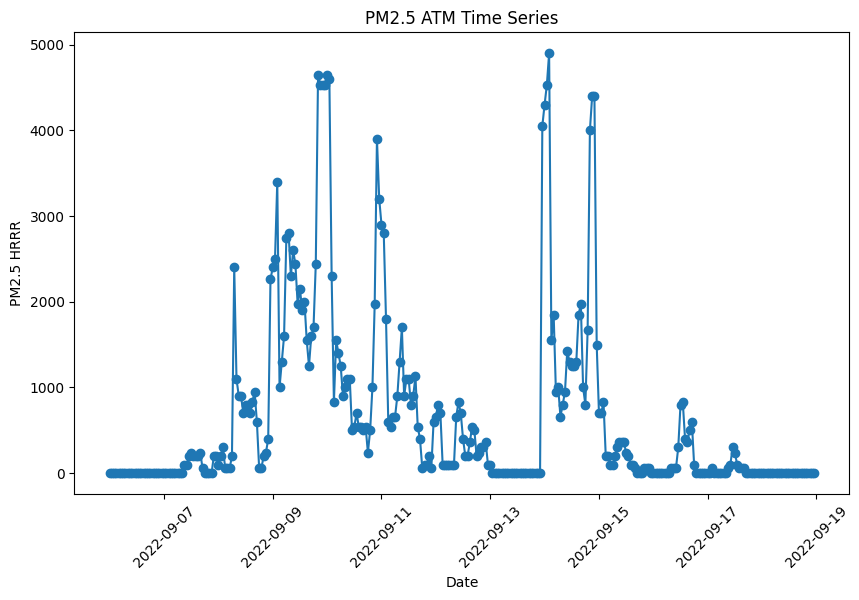

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Read HRRR-Smoke data
df_HRRR_model =pd.read_csv('HRRR_Smoke.csv')
df_HRRR_model['date_string'] = pd.to_datetime(df_HRRR_model['date'])
# Plotting the time series
plt.figure(figsize=(10,6))
plt.plot(df_HRRR_model['date_string'], df_HRRR_model['massden']*1000000000, marker='o', linestyle='-')
plt.title('PM2.5 ATM Time Series')
plt.xlabel('Date')
plt.ylabel('PM2.5 HRRR')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [32]:
# Read PurepleAir Sensors data
df_111415 = pd.read_csv('111415.csv')
df_116649= pd.read_csv('116649.csv')
df_158587 = pd.read_csv('158587.csv')
df_79615= pd.read_csv('79615.csv')
df_8092= pd.read_csv('8092.csv')
cols=['sensor_index','date_string', 'pm2.5_atm']
df_pureple_air = pd.concat([df_111415[cols], df_116649[cols], df_158587[cols], df_79615[cols], df_8092[cols]], ignore_index=True)
df_pureple_air['date_string'] = pd.to_datetime(df_pureple_air['date_string'])

# Read HRRR-Smoke data
df_HRRR_model =pd.read_csv('HRRR_Smoke.csv')
df_HRRR_model['date_string'] = pd.to_datetime(df_HRRR_model['date'])

# Plot HRRR-Smoke vs. PurepleAir
plt.figure(figsize=(10, 6))

for sensor_id, group in df_pureple_air.groupby('sensor_index'):
    plt.plot(group['date_string'], group['pm2.5_atm'],  linestyle='-', label=f'PurpleAir: {sensor_id}')

plt.plot(df_HRRR_model['date_string'], df_HRRR_model['massden']*1000000000,  linestyle='-',color='black', label='HRRR-Smoke')
plt.title('HRRR-Smoke vs. PurepleAir')
plt.xlabel('Date')
plt.ylabel('PM 2.5')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '111415.csv'